In [2]:
from scipy.stats import f_oneway
from scipy.stats import kruskal

import pandas as pd
import numpy as np
import tellurium as te

import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

import gzip
import cloudpickle

In [3]:
os.chdir('..')
from src import util
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### To show that each iteration on the same dataset is statistically the same (ANOVA)

In [ ]:
######### USER-INPUT SECTION
MODEL_FILE_PATH = '../data/interim/Antimony/Simplified_Teusink_yeast.ant'
iteration_folder = '../data/interim/generated_data/simplTeusink-noReg/iterations/'
######### END OF USER-INPUT SECTION

model = te.loada(MODEL_FILE_PATH)
gt=model.getScaledElasticityMatrix().flatten()

# Establish labels for metabolite and reaction names
m_labels = [m for m in model.getFloatingSpeciesIds()]
r_labels = [r for r in model.getReactionIds()]

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                    for mlabel in m_labels] for rlabel in r_labels]).flatten()

ex_file_labels = np.array([['E_' + '{0},{1}'.format(rlabel, mlabel)
                    for mlabel in m_labels] for rlabel in r_labels]).flatten()

# load the predicted Ex dataset
# then reshape into 1000 rows, 176 columns
# plot all data in each column as a scatter plot
# make a plotting method
def run_ANOVA10(colNo, exs101):
    only_iter = []
    for df in exs101:
        only_iter.append(df.loc[:,ex_labels[colNo]])
        # sns.swarmplot(data=df, x=ex_labels[colNo], size=3, alpha=0.8)
    # run ANOVA
    return f_oneway(*only_iter)


def plot_heatmaps(pt_lvl):
    exs101 = []
    for folder in os.listdir(iteration_folder):
        ex101=pd.read_csv(iteration_folder + folder +f'/{pt_lvl}x_PredictedExs.csv', index_col=0).values
        exs101.append(pd.DataFrame(ex101.reshape(1000,176), columns=ex_labels))
    
    fdict= {}
    for i in range(len(ex_labels)):
        fdict[ex_labels[i]]= [run_ANOVA10(i, exs101)[0]]

    a = pd.DataFrame.from_dict(fdict).T
    a['id'] = [idx.strip('$\epsilon_{}') for idx in a.index]
    a.reset_index()
    a['reaction'] = [i.split(',')[0] for i in a['id']]
    a['metabolite'] = [i.split(',')[1] for i in a['id']]
    a.set_index('id', inplace=True)
    a.rename(columns={0:'f-stat'}, inplace=True)
    b = pd.pivot(a, values='f-stat', index='reaction', columns='metabolite')

    sns.heatmap(b, norm=LogNorm())
    plt.title(f'ANOVA f-scores for BMCA iterations of {pt_lvl}x perturbation of data')
    plt.savefig(f'anova_fscores_{pt_lvl}.png')
    plt.close()

In [ ]:
pt = [0.1, 0.2, 0.3, 0.4, 0.5, 1.01, 1.5, 3, 5, 7, 10]
for lvl in pt:
    plot_heatmaps(lvl)


## Visualizing Spearman data 

### Condensing all the spearman r data

In [4]:
os.chdir('../data/results/spearman_coefficients/')

In [5]:
spr_file_list = [i for i in os.listdir() if "topologyA" in i]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_A = pd.concat(spr_dfs)
all_spr_df_A

,Unnamed: 0,r,p-value,lower,upper,reg,omit
0,0.1x,0.567857,2.722836e-02,0.052221,0.843359,noReg,allData
1,0.2x,0.657143,7.770251e-03,0.218771,0.901469,noReg,allData
2,0.3x,0.760714,9.911286e-04,0.334361,0.952727,noReg,allData
3,0.4x,0.896429,6.066143e-06,0.664090,0.974802,noReg,allData
4,0.5x,0.939286,2.094580e-07,0.733528,0.989111,noReg,allData
...,...,...,...,...,...,...,...
6,1.5x,0.757143,1.081108e-03,0.244029,0.960147,reg2,omitIntMet
7,3x,0.675000,5.763499e-03,0.131805,0.890715,reg2,omitIntMet
8,5x,0.725000,2.227032e-03,0.375423,0.920070,reg2,omitIntMet
9,7x,0.489286,6.416039e-02,-0.014442,0.838301,reg2,omitIntMet


In [6]:
os.chdir('../../../notebooks/')

In [7]:
all_spr_df_A.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_A['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_A['perturbation']]

In [8]:
a = all_spr_df_A.pivot(index=['omit', 'reg'], columns='perturbation', values='r')
a

perturbation          0.10      0.20      0.30      0.40      0.50      1.01   \
omit        reg                                                                 
allData     noReg  0.567857  0.657143  0.760714  0.896429  0.939286  0.307143   
            reg1   0.610714  0.682143  0.807143  0.810714  0.810714  0.453571   
            reg2   0.625000  0.514286  0.639286  0.646429  0.625000  0.264286   
omitEnzymes noReg  0.250000  0.225000  0.278571  0.621429  0.796429  0.121429   
            reg1   0.189286  0.217857  0.428571  0.682143  0.782143  0.042857   
            reg2  -0.021429  0.367857  0.260714  0.792857  0.539286  0.271429   
omitExMet   noReg  0.428571  0.671429  0.742857  0.885714  0.932143  0.089286   
            reg1   0.603571  0.585714  0.764286  0.678571  0.821429  0.078571   
            reg2   0.675000  0.614286  0.735714  0.596429  0.657143  0.264286   
omitFluxes  noReg  0.289286  0.296429  0.150000 -0.178571  0.335714  0.382143   
            reg1   0.114286  0.150000  0.428571  0.410714 -0.092857  0.614286   
            reg2   0.010714  0.146429  0.235714  0.089286  0.364286  0.225000   
omitIntMet  noReg  0.085714  0.235714 -0.157143  0.307143  0.650000  0.653571   
            reg1  -0.121429  0.053571  0.010714  0.685714  0.639286  0.292857   
            reg2   0.032143  0.042857  0.464286  0.675000  0.846429 -0.035714   

perturbation          1.50      3.00      5.00      7.00      10.00  
omit        reg                                                      
allData     noReg  0.982143  0.957143  0.953571  0.925000  0.914286  
            reg1   0.767857  0.807143  0.839286  0.825000  0.864286  
            reg2   0.546429  0.646429  0.635714  0.785714  0.896429  
omitEnzymes noReg  0.935714  0.010714  0.403571  0.196429  0.139286  
            reg1   0.667857  0.607143  0.414286  0.239286  0.610714  
            reg2   0.600000  0.310714  0.221429  0.414286  0.342857  
omitExMet   noReg  0.975000  0.971429  0.957143  0.921429  0.903571  
            reg1   0.789286  0.728571  0.796429  0.800000  0.857143  
            reg2   0.525000  0.578571  0.639286  0.721429  0.871429  
omitFluxes  noReg  0.267857  0.096429  0.750000  0.342857  0.117857  
            reg1   0.417857  0.042857  0.332143  0.189286  0.300000  
            reg2   0.157143 -0.096429  0.467857 -0.157143  0.253571  
omitIntMet  noReg  0.925000  0.900000  0.875000  0.789286  0.139286  
            reg1   0.871429  0.721429  0.835714  0.467857 -0.200000  
            reg2   0.757143  0.675000  0.725000  0.489286  0.453571

In [9]:
fluxes_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitFluxes']))]
enzymes_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitEnzymes']))]
intMet_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitIntMet']))]
exMet_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitExMet']))]

###  All-in-one scatter plots

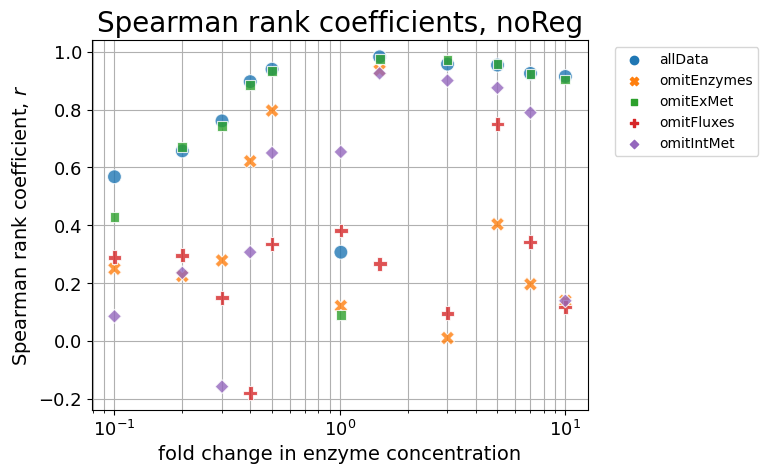

In [9]:
util.plt_spr_scatter(all_spr_df_A.loc[(all_spr_df_A['reg'] =='noReg')], 'Spearman rank coefficients, noReg')

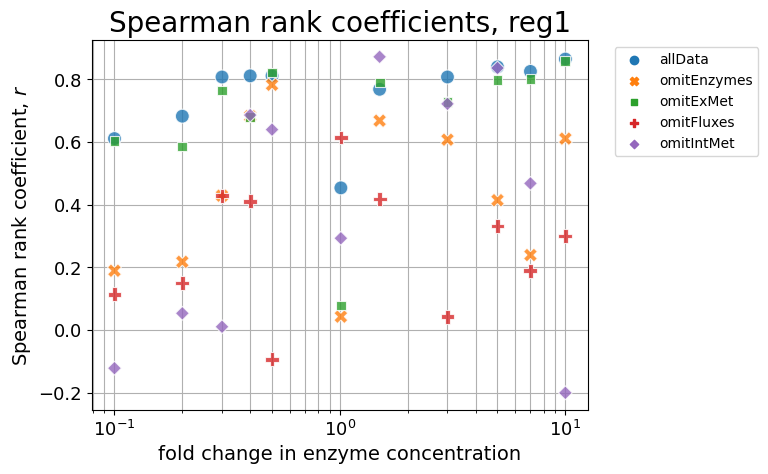

In [10]:
util.plt_spr_scatter(all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg1')], 'Spearman rank coefficients, reg1')

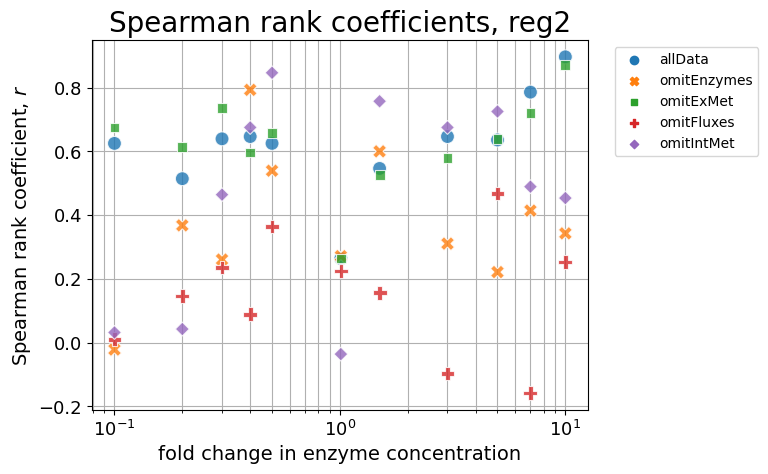

In [11]:
util.plt_spr_scatter(all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2')], 'Spearman rank coefficients, reg2')

## Comparing Spearman r coefficients pairwise to find significant differences
My way of doing that would be to plot the confidence intervals around the
coefficients and compare them. 

Another testing option would be looking at the absolute difference in the ranks 
between a prediction method and the truth. You would have a sample of absolute 
rank differences for each method, but they would not independent (so can't use 
Kruskal-Wallis test). The samples of differences would be dependent ("paired" 
across methods by the observation/value being ranked). A test that you could use
is Friedman's test which is based on ranks (kind of like an extension of the 
Wilcoxon signed rank test for more than 2 "paired"/dependent samples). Post-hoc 
testing could be done using the Wilcoxon signed rank test and using Holm's or 
Bonferroni method to adjust the p-value for multiple testing.

In [9]:
all_spr_df_A = all_spr_df_A[all_spr_df_A['perturbation'] != 1.01]

In [10]:
def plot_CI_comparisons(subplot, omitted_type, reg_level, CRISPRi=True, color='orange'):

    if CRISPRi: 
        df1 = all_spr_df_A[(all_spr_df_A['reg']==reg_level) & (all_spr_df_A['omit']=='allData')][0:5]
        df2 = all_spr_df_A[(all_spr_df_A['reg']==reg_level) & (all_spr_df_A['omit']==f'omit{omitted_type}')][0:5]

        x1 = np.linspace(90,50,5)
        x2 = np.linspace(90,50,5)

    else:
        df1 = all_spr_df_A[(all_spr_df_A['reg']==reg_level) & (all_spr_df_A['omit']=='allData')][5:10]
        df2 = all_spr_df_A[(all_spr_df_A['reg']==reg_level) & (all_spr_df_A['omit']==f'omit{omitted_type}')][5:10]

        x1 = df1['perturbation']
        x2 = df2['perturbation']

    ymin1 = (df1['r'] - df1['lower']).values
    ymax1 = (df1['upper'] - df1['r']).values

    ymin2 = (df2['r'] - df2['lower']).values
    ymax2 = (df2['upper'] - df2['r']).values

    subplot.scatter(x1, 
                abs(df1['r']), alpha=0.8, s=40, zorder=1000, label='all data', 
                color='red')
    subplot.errorbar(x1, df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None', color='red', zorder=100)

    subplot.scatter(x2, 
                abs(df2['r']), alpha=0.8, s=100, zorder=50, 
                label=f'omit {omitted_type}', c=color)
    subplot.errorbar(x2, df2['r'], yerr=np.stack((ymin2, ymax2)), 
                 elinewidth=6, linestyle='None', c=color, zorder=10,
                 alpha=0.8)

    subplot.grid(True, which='both', axis='both', zorder=0)
    subplot.set_ylim([0,1])
        

Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels')

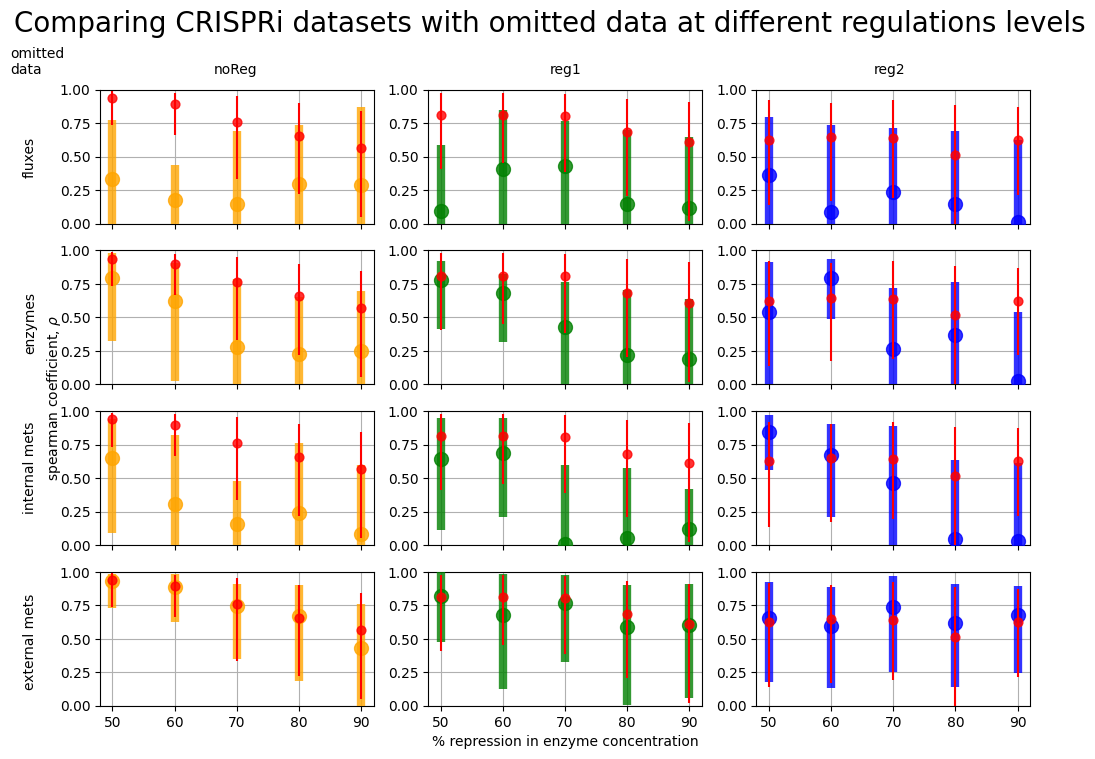

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg")
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg")
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg")
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg")
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", color='blue')

fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels')

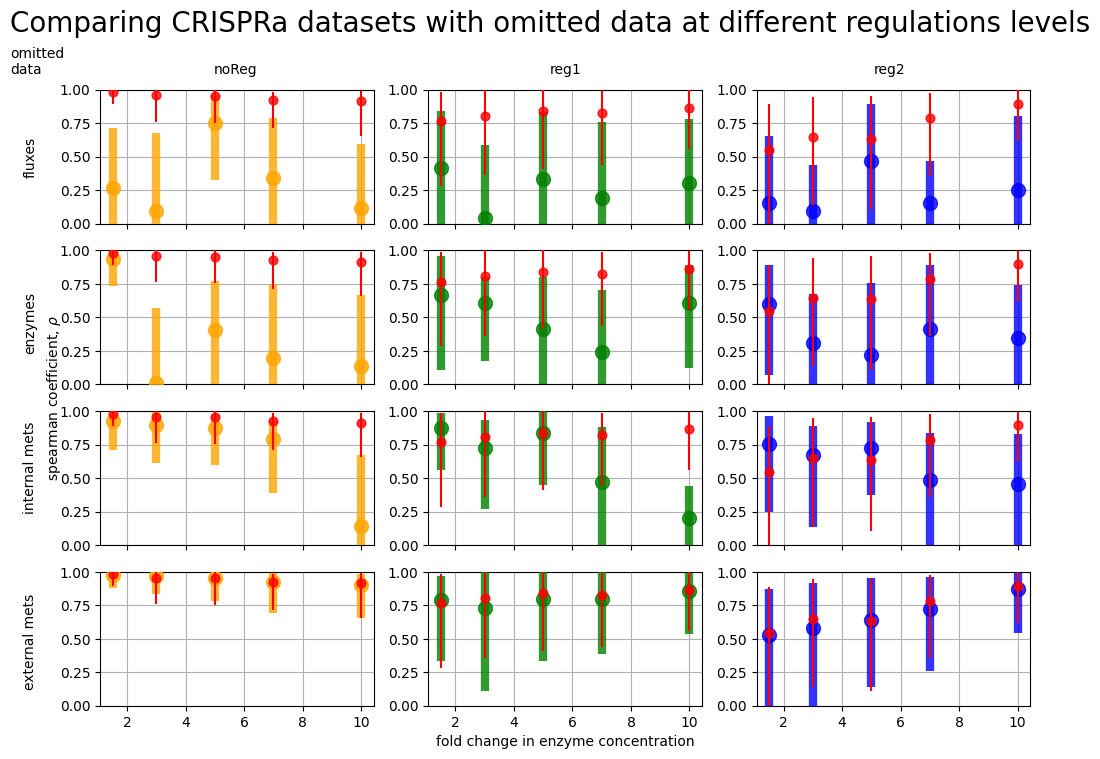

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", CRISPRi=False, color='blue')


fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels", size=20)


### Comprehensive bar plots

In [13]:
#a
noReg_df = all_spr_df_A[all_spr_df_A['reg'] == 'noReg']
noReg_df['r'] = noReg_df['r'].round(3)
noReg_df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_24972\1508152885.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,perturbation,r,p-value,lower,upper,reg,omit
0,0.1,0.568,2.722836e-02,0.052221,0.843359,noReg,allData
1,0.2,0.657,7.770251e-03,0.218771,0.901469,noReg,allData
2,0.3,0.761,9.911286e-04,0.334361,0.952727,noReg,allData
3,0.4,0.896,6.066143e-06,0.664090,0.974802,noReg,allData
4,0.5,0.939,2.094580e-07,0.733528,0.989111,noReg,allData


Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, A-noReg')

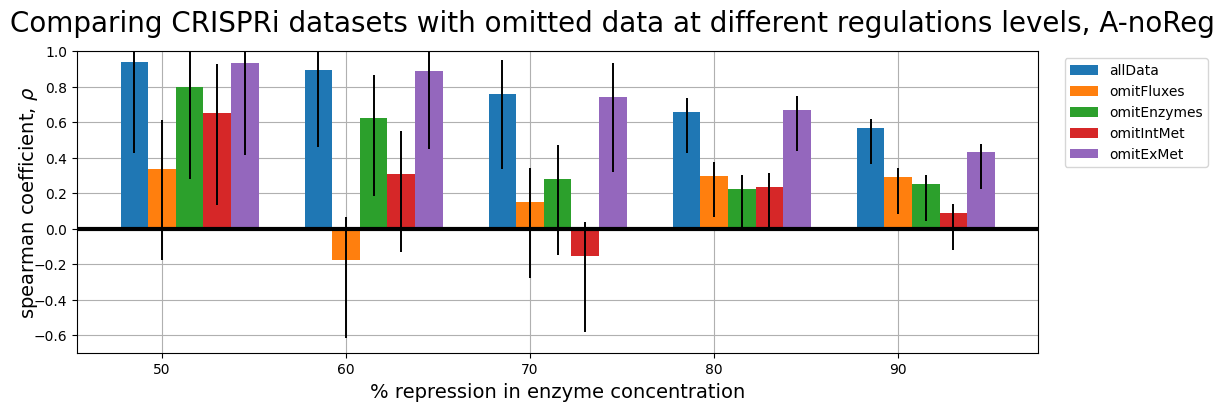

In [14]:
species = list(all_spr_df_A['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

ymin = (noReg_df['r'] - noReg_df['lower']).values[0:5]
ymax = (noReg_df['upper'] - noReg_df['r']).values[0:5]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((-0.7,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, A-noReg", size=20)





Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, A-noReg')

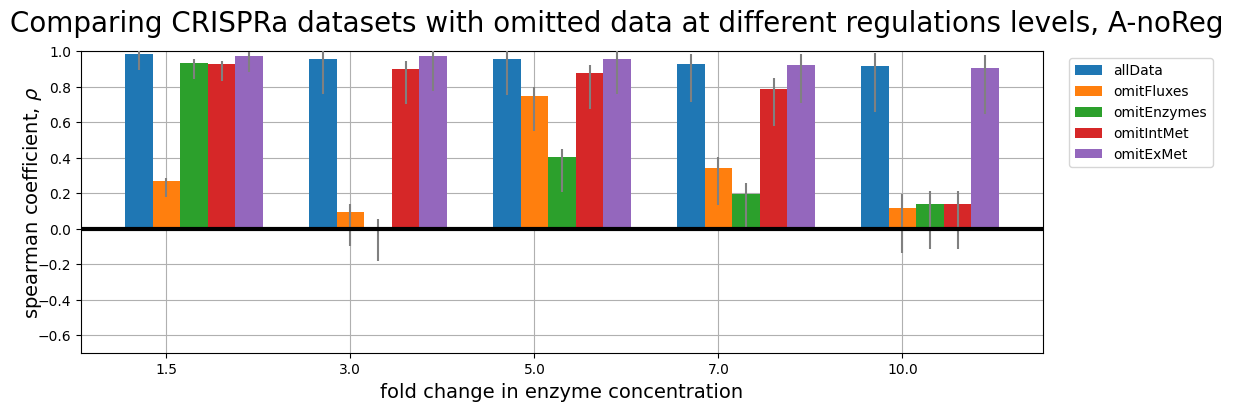

In [15]:
species = all_spr_df_A['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['r']).values[5:10])
}

ymin = (noReg_df['r'] - noReg_df['lower']).values[5:10]
ymax = (noReg_df['upper'] - noReg_df['r']).values[5:10]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='gray', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((-0.7,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, A-noReg", size=20)


In [16]:
A_reg1_df = all_spr_df_A[all_spr_df_A['reg'] == 'reg1']
A_reg1_df['r'] = A_reg1_df['r'].round(3)

A_reg2_df = all_spr_df_A[all_spr_df_A['reg'] == 'reg2']
A_reg2_df['r'] = A_reg2_df['r'].round(3)


C:\Users\user\AppData\Local\Temp\ipykernel_24972\570882700.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_24972\570882700.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, A-reg1')

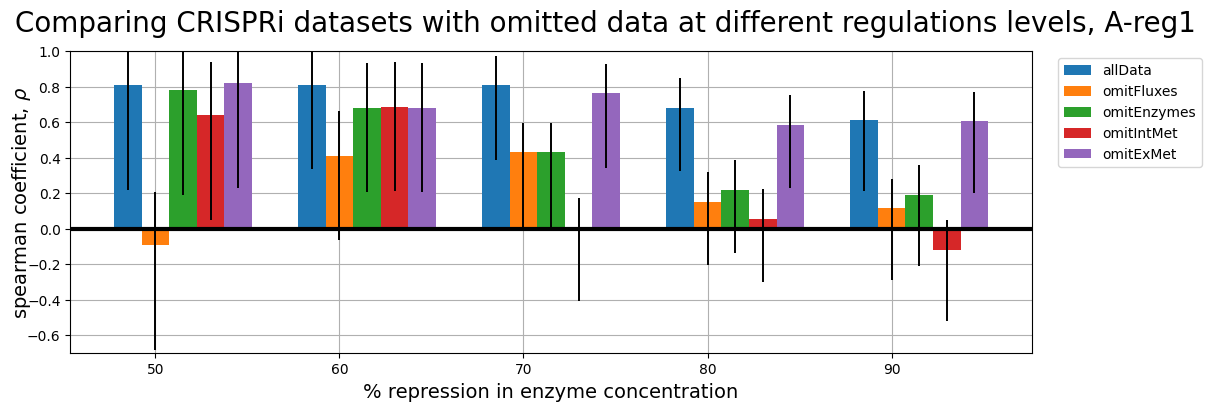

In [21]:
species = list(A_reg1_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((A_reg1_df[A_reg1_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

ymin = (A_reg1_df['r'] - A_reg1_df['lower']).values[0:5]
ymax = (A_reg1_df['upper'] - A_reg1_df['r']).values[0:5]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((-0.7,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, A-reg1", size=20)

Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, A-reg1')

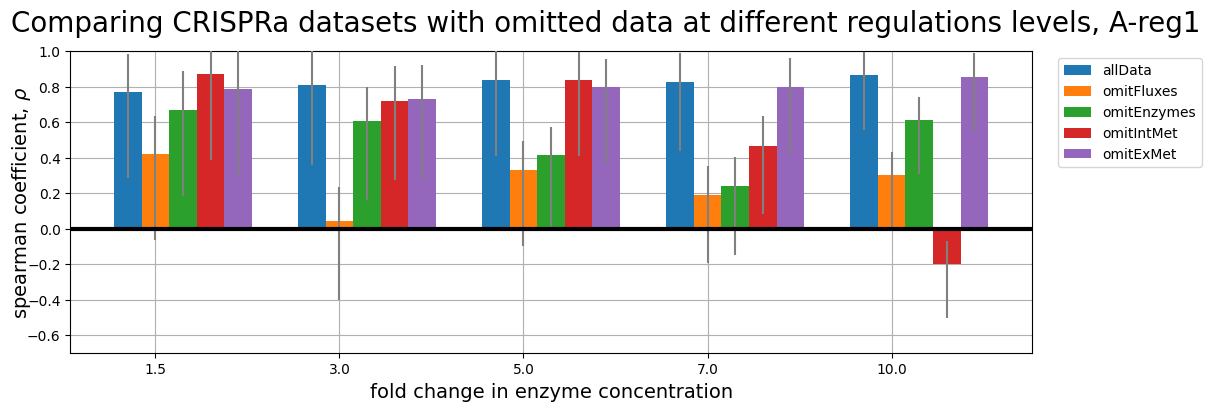

In [24]:
species = all_spr_df_A['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((A_reg1_df[A_reg1_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((A_reg1_df[A_reg1_df['omit'] == 'omitExMet']['r']).values[5:10])
}

ymin = (A_reg1_df['r'] - A_reg1_df['lower']).values[5:10]
ymax = (A_reg1_df['upper'] - A_reg1_df['r']).values[5:10]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='gray', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((-0.7,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, A-reg1", size=20)


Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, A-reg2')

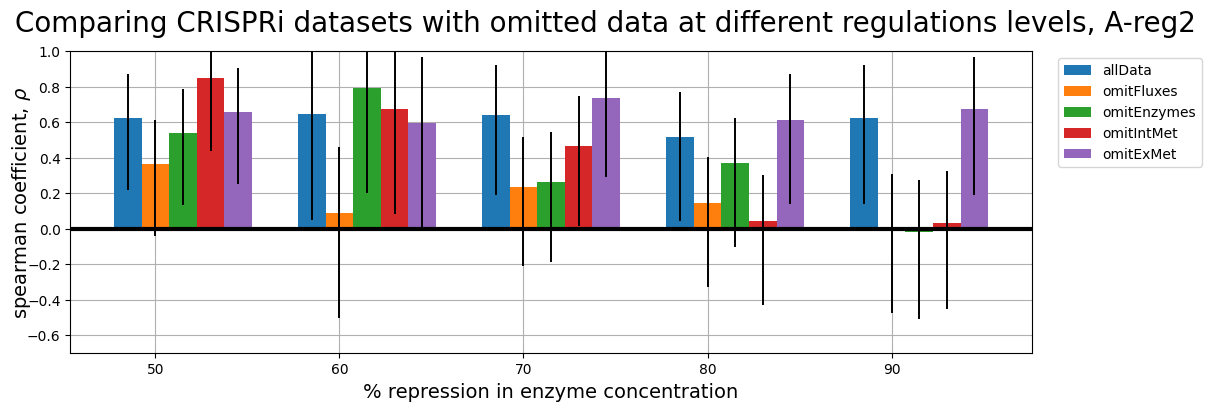

In [22]:
species = list(all_spr_df_A['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((A_reg2_df[A_reg2_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

ymin = (A_reg2_df['r'] - A_reg2_df['lower']).values[0:5]
ymax = (A_reg2_df['upper'] - A_reg2_df['r']).values[0:5]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((-0.7,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, A-reg2", size=20)

Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, A-reg2')

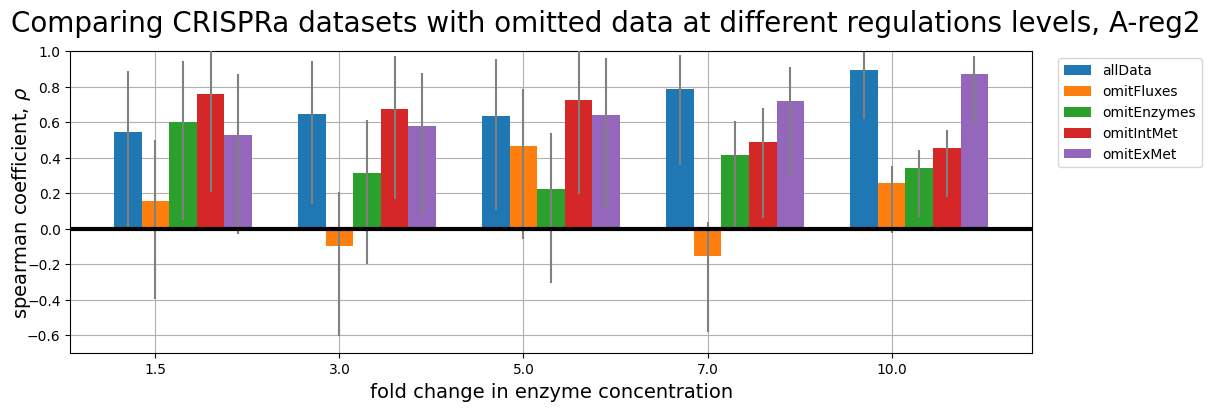

In [23]:
species = all_spr_df_A['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((A_reg2_df[A_reg2_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((A_reg2_df[A_reg2_df['omit'] == 'omitExMet']['r']).values[5:10])
}

ymin = (A_reg2_df['r'] - A_reg2_df['lower']).values[5:10]
ymax = (A_reg2_df['upper'] - A_reg2_df['r']).values[5:10]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='gray', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((-0.7,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, A-reg2", size=20)


## Visualizing MAE across the different types of data

In [10]:
os.chdir('../data/results/MAE/')
MAE_file_list = [i for i in os.listdir() if "topologyA" in i]

MAE_dfs = []
for file in MAE_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    MAE_dfs.append(a)

all_MAE_df_A = pd.concat(MAE_dfs)
all_MAE_df_A

os.chdir('../../../notebooks/')


In [11]:
all_MAE_df_A.columns = ['perturbation', 'values', 'reg', 'omit']
all_MAE_df_A['values'] = all_MAE_df_A['values']/176
all_MAE_df_A

,perturbation,values,reg,omit
0,gt,0.000000,noReg,allData
1,knockout,0.073197,noReg,allData
2,0.1x,0.052506,noReg,allData
3,0.2x,0.037722,noReg,allData
4,0.3x,0.025639,noReg,allData
...,...,...,...,...
6,1.5x,0.123228,reg2,omitIntMet
7,3x,0.103600,reg2,omitIntMet
8,5x,0.112900,reg2,omitIntMet
9,7x,0.096056,reg2,omitIntMet


In [12]:
a = all_MAE_df_A.pivot(index=['omit', 'reg'], columns='perturbation', values='values')

all_MAE_df_A = all_MAE_df_A[all_MAE_df_A['perturbation'] != 1.01]
all_MAE_df_A = all_MAE_df_A[all_MAE_df_A['perturbation'] != 'knockout']


C:\Users\user\AppData\Local\Temp\ipykernel_9424\564638638.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, A-noReg')

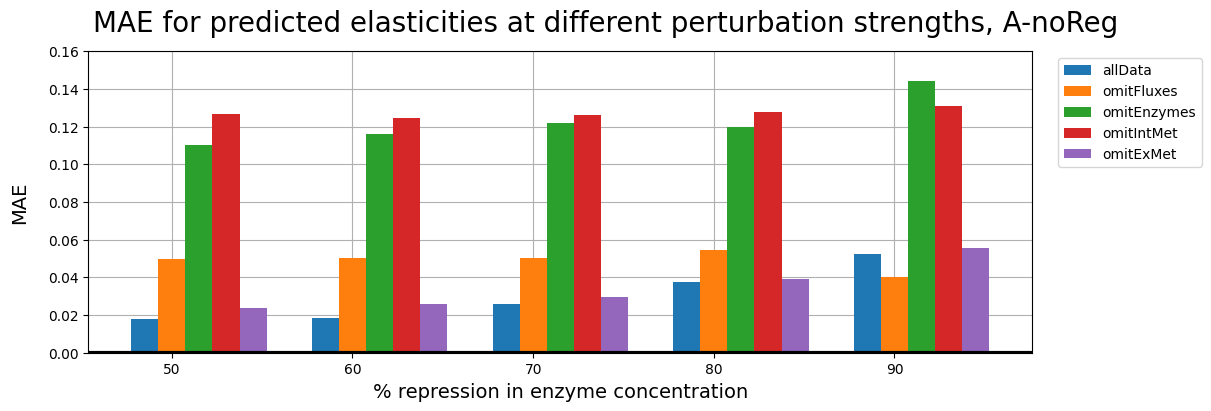

In [13]:
noReg_df = all_MAE_df_A[all_MAE_df_A['reg'] == 'noReg']
noReg_df['r'] = noReg_df['values'].round(3)
noReg_df.head()

species = list(all_MAE_df_A['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,.16))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, A-noReg", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, A-noReg')

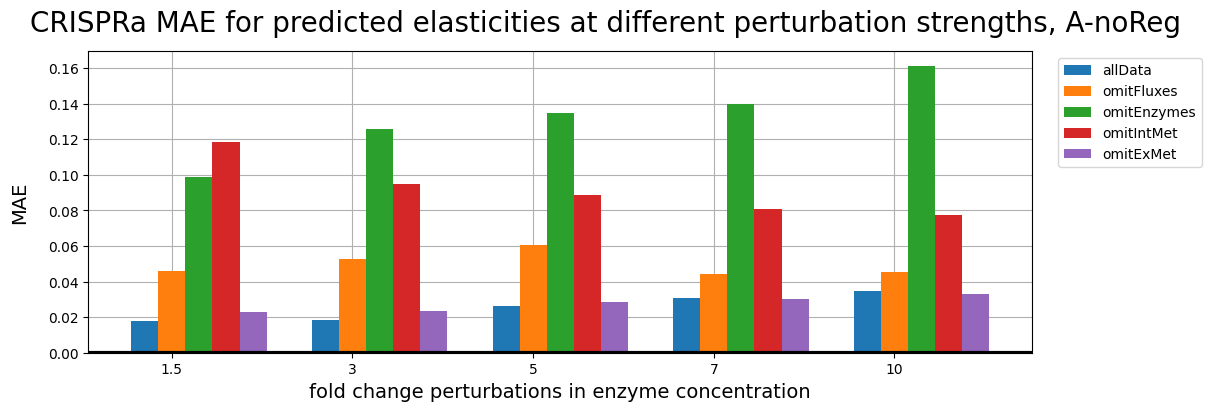

In [14]:
species = list(all_MAE_df_A['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, A-noReg", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_9424\1988152521.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, A-reg1')

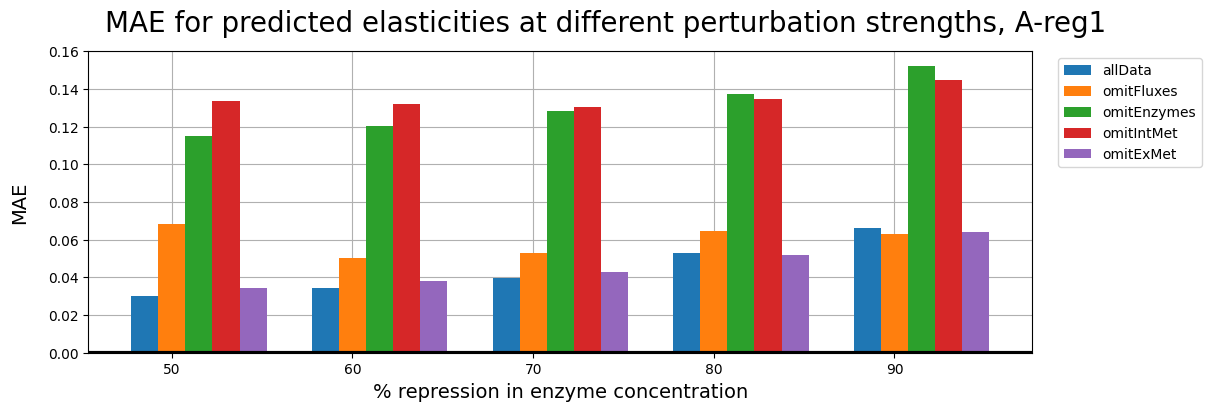

In [15]:
reg1_df = all_MAE_df_A[all_MAE_df_A['reg'] == 'reg1']
reg1_df['r'] = reg1_df['values'].round(3)
reg1_df.head()

species = list(all_MAE_df_A['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,.16))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, A-reg1", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg1')

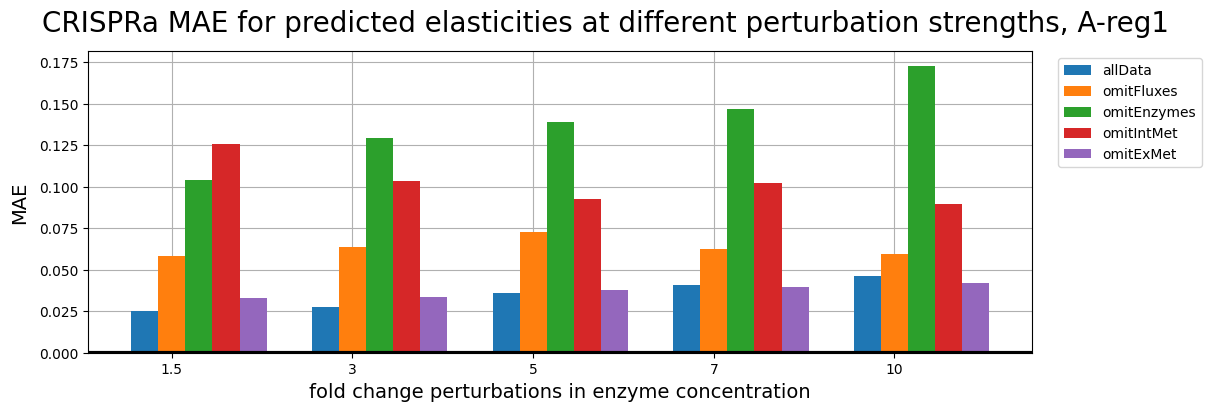

In [16]:
species = list(all_MAE_df_A['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg1", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_9424\1577642095.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, A-reg2')

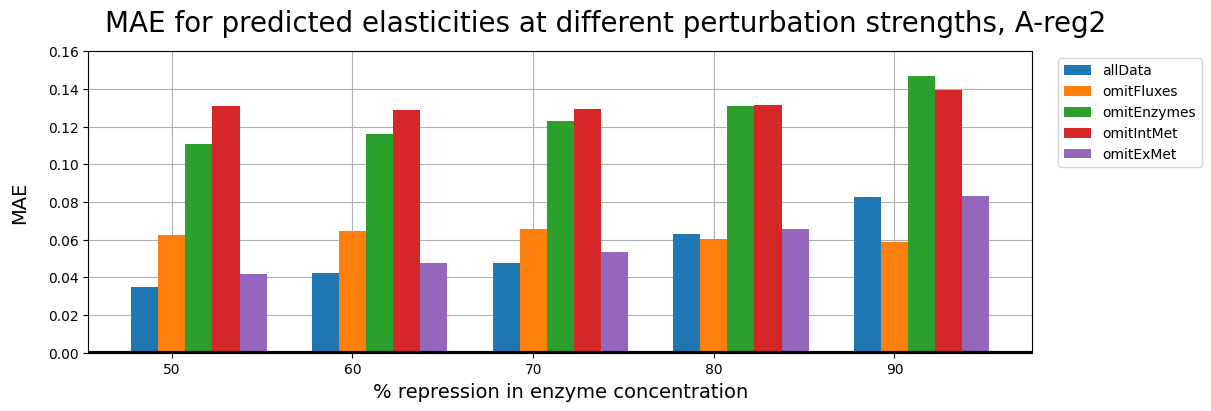

In [17]:
reg2_df = all_MAE_df_A[all_MAE_df_A['reg'] == 'reg2']
reg2_df['r'] = reg2_df['values'].round(3)
reg2_df.head()

species = list(all_MAE_df_A['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,.16))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, A-reg2", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg2')

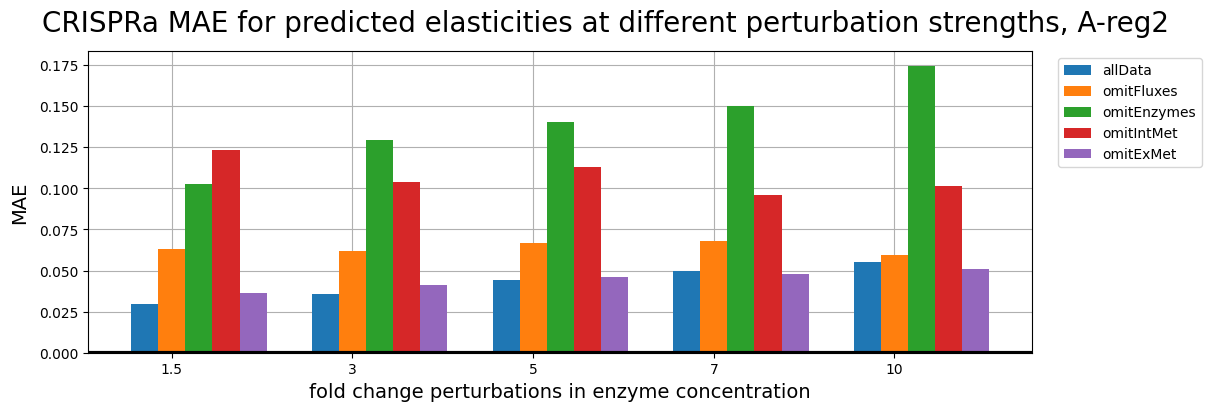

In [18]:
species = list(all_MAE_df_A['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg2", size=20)


## Make tables of ranking correctness

In [2]:
os.chdir('../data/results/rankings/')

In [3]:
rank_file_list = [i for i in os.listdir() if "topologyA" in i]

rank_dfs = []
for file in rank_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    rank_dfs.append(a)

all_rank_df_A = pd.concat(rank_dfs).drop('1.01x', axis=1)
all_rank_df_A

,vYAN,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x,reg,omit
0,1.0,vWHI,vXRA,vXRA,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,noReg,allData
1,2.0,vQUE,vNOV,vWHI,vXRA,vXRA,vXRA,vQUE,vQUE,vQUE,vXRA,vLIM,noReg,allData
2,3.0,vLIM,vOSC,vNOV,vNOV,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vXRA,noReg,allData
3,4.0,vXRA,vWHI,vKIL,vKIL,vNOV,vQUE,vROM,vXRA,vXRA,vQUE,vQUE,noReg,allData
4,5.0,vROM,vKIL,vOSC,vLIM,vQUE,vNOV,vXRA,vROM,vROM,vPAP,vPAP,noReg,allData
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12.0,vZUL,vWHI,vNOV,vPAP,vMIK,vQUE,vUNI,vROM,vXRA,vSIE,vSIE,reg2,omitIntMet
12,13.0,vROM,vZUL,vPAP,vMIK,vOSC,vVIC,vVIC,vZUL,vSIE,vROM,vMIK,reg2,omitIntMet
13,14.0,vPAP,vOSC,vZUL,vWHI,vROM,vMIK,vROM,vSIE,vTAN,vMIK,vWHI,reg2,omitIntMet
14,15.0,vMIK,vMIK,vMIK,vOSC,vSIE,vROM,vMIK,vMIK,vMIK,vVIC,vOSC,reg2,omitIntMet


In [4]:
os.chdir('../../../notebooks/')

In [5]:
topThree_df = all_rank_df_A[all_rank_df_A['vYAN'].isin([1, 2, 3])]

gt_ranks = all_rank_df_A['gt'].head(15)

rank_noReg = topThree_df[topThree_df['reg']=='noReg'].drop('gt', axis=1)
rank_reg1 = topThree_df[topThree_df['reg']=='reg1'].drop('gt', axis=1)
rank_reg2 = topThree_df[topThree_df['reg']=='reg2'].drop('gt', axis=1)

In [6]:
rank_noReg_sorted = rank_noReg.pivot(index='omit',columns='vYAN').drop('reg', axis=1)
rank_noReg_sorted

0.1x              0.2x              0.3x              0.4x  ...  \
vYAN          1.0   2.0   3.0   1.0   2.0   3.0   1.0   2.0   3.0   1.0  ...   
omit                                                                     ...   
allData      vXRA  vNOV  vOSC  vXRA  vWHI  vNOV  vWHI  vXRA  vNOV  vWHI  ...   
omitEnzymes  vKIL  vNOV  vXRA  vSIE  vPAP  vTAN  vXRA  vKIL  vLIM  vXRA  ...   
omitExMet    vXRA  vNOV  vKIL  vXRA  vWHI  vNOV  vXRA  vWHI  vNOV  vWHI  ...   
omitFluxes   vXRA  vNOV  vKIL  vOSC  vXRA  vROM  vXRA  vKIL  vQUE  vOSC  ...   
omitIntMet   vQUE  vKIL  vOSC  vUNI  vTAN  vROM  vROM  vQUE  vVIC  vPAP  ...   

               3x    5x                7x               10x              
vYAN          3.0   1.0   2.0   3.0   1.0   2.0   3.0   1.0   2.0   3.0  
omit                                                                     
allData      vLIM  vWHI  vQUE  vLIM  vWHI  vXRA  vLIM  vWHI  vLIM  vXRA  
omitEnzymes  vUNI  vXRA  vLIM  vNOV  vXRA  vLIM  vNOV  vXRA  vLIM  vNOV  
omitExMet    vLIM  vWHI  vLIM  vQUE  vWHI  vLIM  vQUE  vWHI  vQUE  vLIM  
omitFluxes   vROM  vLIM  vOSC  vQUE  vXRA  vQUE  vNOV  vXRA  vPAP  vNOV  
omitIntMet   vQUE  vWHI  vTAN  vUNI  vWHI  vROM  vSIE  vLIM  vKIL  vWHI  

[5 rows x 30 columns]

In [7]:
# based off the table above, convert all the reaction names into ground truth ranks
gt_numbering_df = rank_noReg_sorted.applymap(lambda x: list(gt_ranks).index(x))
gt_numbering_df = gt_numbering_df.melt(ignore_index=False).reset_index()
gt_numbering_df['vYAN'] = gt_numbering_df['vYAN'].astype(int)
gt_numbering_df

,omit,None,vYAN,value
0,allData,0.1x,1,3
1,omitEnzymes,0.1x,1,10
2,omitExMet,0.1x,1,3
3,omitFluxes,0.1x,1,3
4,omitIntMet,0.1x,1,1
...,...,...,...,...
145,allData,10x,3,3
146,omitEnzymes,10x,3,6
147,omitExMet,10x,3,2
148,omitFluxes,10x,3,6


In [8]:
gt_numbering_df['difference'] = abs(gt_numbering_df['value'].subtract(gt_numbering_df['vYAN']))
gt_numbering_df

,omit,None,vYAN,value,difference
0,allData,0.1x,1,3,2
1,omitEnzymes,0.1x,1,10,9
2,omitExMet,0.1x,1,3,2
3,omitFluxes,0.1x,1,3,2
4,omitIntMet,0.1x,1,1,0
...,...,...,...,...,...
145,allData,10x,3,3,0
146,omitEnzymes,10x,3,6,3
147,omitExMet,10x,3,2,1
148,omitFluxes,10x,3,6,3


In [9]:
gt_differences_df = gt_numbering_df.pivot(index='omit',columns=[None, 'vYAN'],values='difference')
gt_differences_df

0.1x       0.2x        0.3x        0.4x  ... 3x 5x        7x     \
vYAN           1  2  3    1   2  3    1  2   3    1  ...  3  1   2  3  1  2   
omit                                                 ...                      
allData        2  4  2    2   2  3    1  1   3    1  ...  1  1   1  1  1  1   
omitEnzymes    9  4  0    7   5  9    2  8   1    2  ...  8  2   0  3  2  0   
omitExMet      2  4  7    2   2  3    2  2   3    1  ...  1  1   0  2  1  0   
omitFluxes     2  4  7    4   1  1    2  8   2    4  ...  1  1   3  2  2  1   
omitIntMet     0  8  2   10  10  1    3  1  10    6  ...  2  1  10  8  1  2   

               10x        
vYAN         3   1  2  3  
omit                      
allData      1   1  0  0  
omitEnzymes  3   2  0  3  
omitExMet    2   1  1  1  
omitFluxes   3   2  5  3  
omitIntMet   5   1  8  3  

[5 rows x 30 columns]

In [10]:
def condition(x):
    if x==0:
        return 0
    elif x<3:
        return 1
    else:
        return 2

diff_color_df = gt_differences_df.applymap(lambda x: condition(x))
diff_color_df

0.1x       0.2x       0.3x       0.4x  ... 3x 5x       7x        \
vYAN           1  2  3    1  2  3    1  2  3    1  ...  3  1  2  3  1  2  3   
omit                                               ...                        
allData        1  2  1    1  1  2    1  1  2    1  ...  1  1  1  1  1  1  1   
omitEnzymes    2  2  0    2  2  2    1  2  1    1  ...  2  1  0  2  1  0  2   
omitExMet      1  2  2    1  1  2    1  1  2    1  ...  1  1  0  1  1  0  1   
omitFluxes     1  2  2    2  1  1    1  2  1    2  ...  1  1  2  1  1  1  2   
omitIntMet     0  2  1    2  2  1    2  1  2    2  ...  1  1  2  2  1  1  2   

            10x        
vYAN          1  2  3  
omit                   
allData       1  0  0  
omitEnzymes   1  0  2  
omitExMet     1  1  1  
omitFluxes    1  2  2  
omitIntMet    1  2  2  

[5 rows x 30 columns]

In [34]:
yticklabels = []
for i in gt_numbering_df[None].unique():
    yticklabels = yticklabels+['\n1', i + '\n2', '\n3']

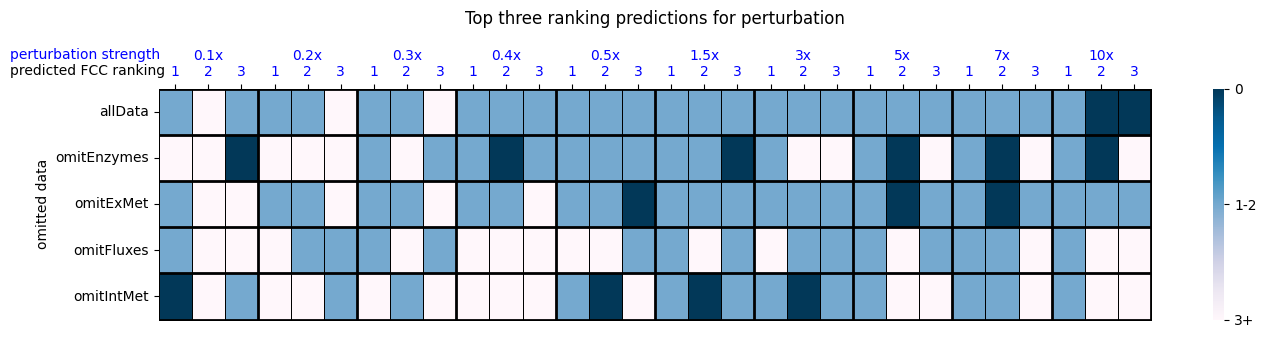

In [72]:
plt.figure(figsize=(16, 3))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.axes().xaxis.set_label_position('top')

ax = sns.heatmap(diff_color_df, linewidths=0.5, linecolor='black', clip_on=False, 
            cmap='PuBu_r', cbar_kws={"ticks":[0,1,2]})
plt.title("Top three ranking predictions for perturbation, A-noReg")
plt.xlabel('perturbation levels', c='w')
plt.text(-4.5, -0.65, "perturbation strength", c='b')
plt.text(-4.5, -0.3, "predicted FCC ranking")
plt.ylabel('omitted data')

plt.xticks(np.arange(0.5, 30.5),labels=yticklabels, rotation=0, c='b')

for i in range(10):
    plt.axvline(3*(i+1), linewidth=2, color='k')

for i in range(6):
    plt.axhline(i, linewidth=2, color='k')

c_bar = ax.collections[0].colorbar
# c_bar.set_ticks([-2, 0, 2])
c_bar.set_ticklabels(['0', '1-2', '3+'])
plt.gcf().axes[1].invert_yaxis()

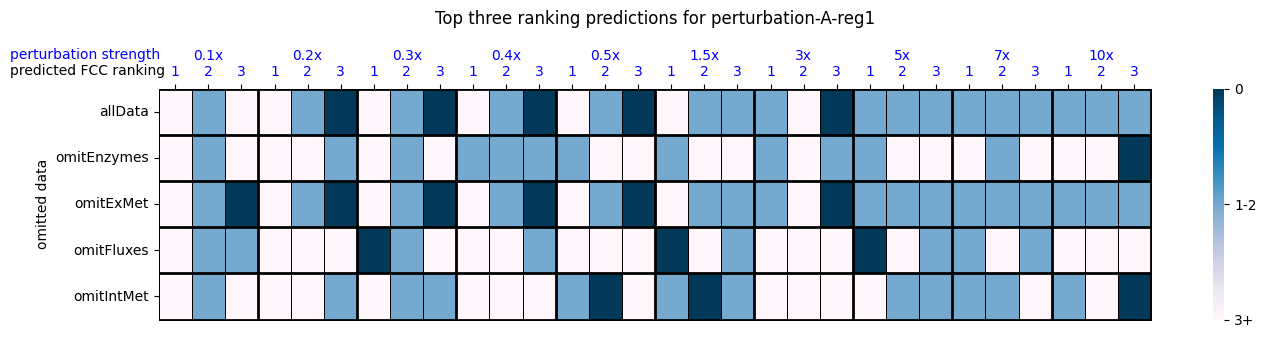

In [74]:
rank_reg1_sorted = rank_reg1.pivot(index='omit',columns='vYAN').drop('reg', axis=1)
gt_numbering_df = rank_reg1_sorted.applymap(lambda x: list(gt_ranks).index(x))
gt_numbering_df = gt_numbering_df.melt(ignore_index=False).reset_index()
gt_numbering_df['vYAN'] = gt_numbering_df['vYAN'].astype(int)
gt_numbering_df['difference'] = abs(gt_numbering_df['value'].subtract(gt_numbering_df['vYAN']))
gt_differences_df = gt_numbering_df.pivot(index='omit',columns=[None, 'vYAN'],values='difference')
diff_color_df = gt_differences_df.applymap(lambda x: condition(x))

plt.figure(figsize=(16, 3))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.axes().xaxis.set_label_position('top')
ax = sns.heatmap(diff_color_df, linewidths=0.5, linecolor='black', clip_on=False, 
            cmap='PuBu_r', cbar_kws={"ticks":[0,1,2]})
plt.title("Top three ranking predictions for perturbation, A-reg1")
plt.xlabel('perturbation levels', c='w')
plt.text(-4.5, -0.65, "perturbation strength", c='b')
plt.text(-4.5, -0.3, "predicted FCC ranking")
plt.ylabel('omitted data')

plt.xticks(np.arange(0.5, 30.5),labels=yticklabels, rotation=0, c='b')

for i in range(10):
    plt.axvline(3*(i+1), linewidth=2, color='k')

for i in range(6):
    plt.axhline(i, linewidth=2, color='k')

c_bar = ax.collections[0].colorbar
c_bar.set_ticklabels(['0', '1-2', '3+'])
plt.gcf().axes[1].invert_yaxis()

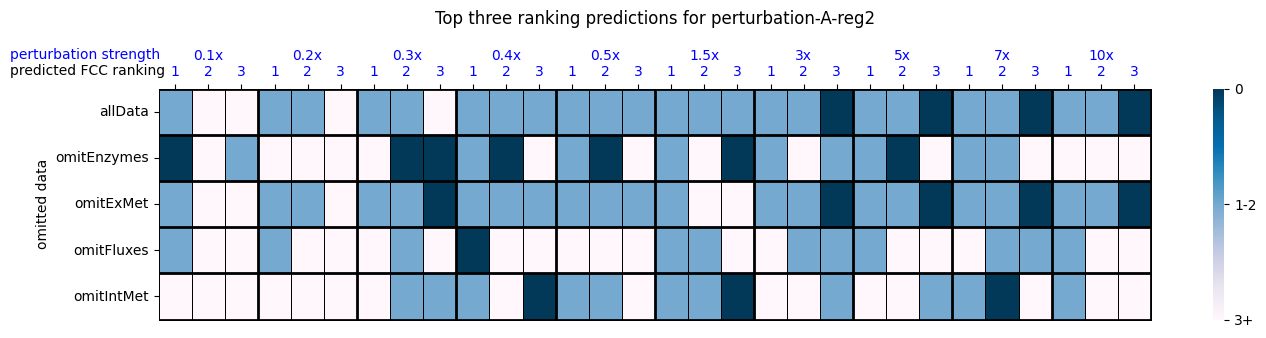

In [75]:
rank_reg2_sorted = rank_reg2.pivot(index='omit',columns='vYAN').drop('reg', axis=1)
gt_numbering_df = rank_reg2_sorted.applymap(lambda x: list(gt_ranks).index(x))
gt_numbering_df = gt_numbering_df.melt(ignore_index=False).reset_index()
gt_numbering_df['vYAN'] = gt_numbering_df['vYAN'].astype(int)
gt_numbering_df['difference'] = abs(gt_numbering_df['value'].subtract(gt_numbering_df['vYAN']))
gt_differences_df = gt_numbering_df.pivot(index='omit',columns=[None, 'vYAN'],values='difference')
diff_color_df = gt_differences_df.applymap(lambda x: condition(x))

plt.figure(figsize=(16, 3))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.axes().xaxis.set_label_position('top')
ax = sns.heatmap(diff_color_df, linewidths=0.5, linecolor='black', clip_on=False, 
            cmap='PuBu_r', cbar_kws={"ticks":[0,1,2]})
plt.title("Top three ranking predictions for perturbation, A-reg2")
plt.xlabel('perturbation levels', c='w')
plt.text(-4.5, -0.65, "perturbation strength", c='b')
plt.text(-4.5, -0.3, "predicted FCC ranking")
plt.ylabel('omitted data')

plt.xticks(np.arange(0.5, 30.5),labels=yticklabels, rotation=0, c='b')

for i in range(10):
    plt.axvline(3*(i+1), linewidth=2, color='k')

for i in range(6):
    plt.axhline(i, linewidth=2, color='k')

c_bar = ax.collections[0].colorbar
c_bar.set_ticklabels(['0', '1-2', '3+'])
plt.gcf().axes[1].invert_yaxis()

## How do different perturbation strengths affect the fidelity of BMCA?

In [21]:
picklefolder = '../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyA-noReg_allData_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [81]:
trace0=traces['trace0']
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

In [ ]:
Ex0_advi = util.get_az_summary(trace0)
Ex01_advi = util.get_az_summary(trace01)
Ex02_advi = util.get_az_summary(trace02)
Ex03_advi = util.get_az_summary(trace03)
Ex04_advi = util.get_az_summary(trace04)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

In [90]:
#CRISPRi
print(f_oneway(Ex0_advi, Ex01_advi, Ex02_advi, Ex03_advi, Ex04_advi, Ex05_advi))
print(kruskal(Ex0_advi, Ex01_advi, Ex02_advi, Ex03_advi, Ex04_advi, Ex05_advi))

F_onewayResult(statistic=0.5580093375586954, pvalue=0.7322729070155803)
KruskalResult(statistic=11.683792136961378, pvalue=0.03938707336372746)


In [89]:
#CRISPRa
print(f_oneway(Ex15_advi, Ex3_advi, Ex5_advi, Ex7_advi, Ex100_advi))
print(kruskal(Ex15_advi, Ex3_advi, Ex5_advi, Ex7_advi, Ex100_advi))

F_onewayResult(statistic=0.004644529633363183, pvalue=0.999957026143241)
KruskalResult(statistic=3.2722231787568736, pvalue=0.5133452589510712)


## How does the presence of regulators affect BMCA’s performance?


In [51]:
with gzip.open(picklefolder + 'topologyA-noReg_allData_traces.pgz', "rb") as f:
    traces_noReg = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + 'topologyA-reg1_allData_traces.pgz', "rb") as f:
    traces_reg1 = cloudpickle.load(f, encoding='bytes')

with gzip.open(picklefolder + 'topologyA-reg2_allData_traces.pgz', "rb") as f:
    traces_reg2 = cloudpickle.load(f, encoding='bytes')

In [55]:
from statsmodels.stats.anova import AnovaRM 
  
trace05_noReg=traces_noReg['trace05']
trace15_noReg=traces_noReg['trace15']
trace05_reg1=traces_reg1['trace05']
trace15_reg1=traces_reg1['trace15']
trace05_reg2=traces_reg2['trace05']
trace15_reg2=traces_reg2['trace15']

In [72]:
a = util.get_az_summary(trace05_noReg)
b = util.get_az_summary(trace05_reg1)
c = util.get_az_summary(trace05_reg2)

d = util.get_az_summary(trace15_noReg)
e = util.get_az_summary(trace15_reg1)
f = util.get_az_summary(trace15_reg2)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [78]:
anovaRM_df = pd.DataFrame() # columns=['reg', 'elasticity', ' value']
anovaRM_df['reg']=['noReg']*176 + ['reg1']*176 + ['reg2']*176
anovaRM_df['elasticity']=np.tile(np.arange(176), 3)
anovaRM_df['value_05']=np.concatenate([a,b,c])
anovaRM_df['value_15']=np.concatenate([d,e,f])

In [80]:
print(AnovaRM(data=anovaRM_df, depvar='value_15', subject='reg', within=['elasticity']).fit())

                   Anova
           F Value  Num DF   Den DF  Pr > F
-------------------------------------------
elasticity 98.4126 175.0000 350.0000 0.0000

